In [15]:
# ECON204C - Week 3 
# The Aiyagari Model
# Retrieved from QuantEcon
# Woongchan Jeon
# April 17 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import quantecon as qe
from quantecon.markov import DiscreteDP

%matplotlib inline

In [2]:
# Define class "Household"

class Household:
    """
    
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n-1}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i

    To invert this map, use

        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                r=0.01,                      # Interest rate
                w=1.0,                       # Wages
                β=0.96,                      # Discount factor
                z_vals=[0.1, 1.0],           # Exogenous states (idiosyncratic productivity)
                Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain                
                a_min=1e-10,                 # Lower bound for asset space
                a_max=18,                    # Upper bound for asset space
                a_size=200):                 # Grid size for asset space 

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)               # Convert input into array
        self.z_vals = np.asarray(z_vals)      
        self.z_size = len(z_vals)            # Size of z values

        self.a_vals = np.linspace(a_min, a_max, a_size) # Discretize asset space into [a_min, \cdots, a_max]
        self.n = a_size * self.z_size                   # length of (A \times S)

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices. Calling the method will trigger a re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R,
                self.a_size,
                self.z_size,
                self.a_vals,
                self.z_vals,
                self.r,
                self.w)


# Do the hard work using JIT-ed functions

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:                        # Otherwise, it is -\infty 
                R[s_i, new_a_i] = np.log(c)  # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for new_a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, new_a_i, new_a_i*z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)                         # Initialize marginal distribution of asset
    for a_i in range(a_size):                          # Pick a specific asset grid
        for z_i in range(z_size):                     
            a_probs[a_i] += s_probs[a_i*z_size + z_i]  # Sum over productivity space 
    return a_probs         

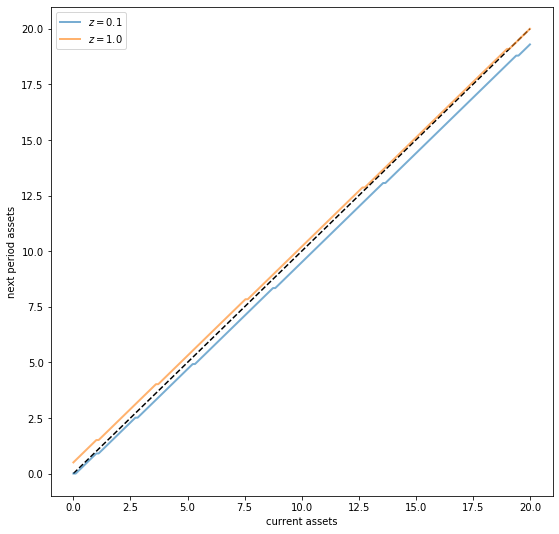

In [3]:
# Example prices
r = 0.03   # Rent
w = 0.956  # Wage

# Create an instance of heterogeneous households
am = Household(a_max=20, r=r, w=w)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Solve using policy function iteration
results = am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = np.empty((a_size, z_size)) # Initialize policy function
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[a_i, z_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')  # 45 degrees
for i in range(z_size):
    lb = f'$z = {z_vals[i]:.2}$'
    ax.plot(a_vals, a_star[:, i], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')

plt.show()

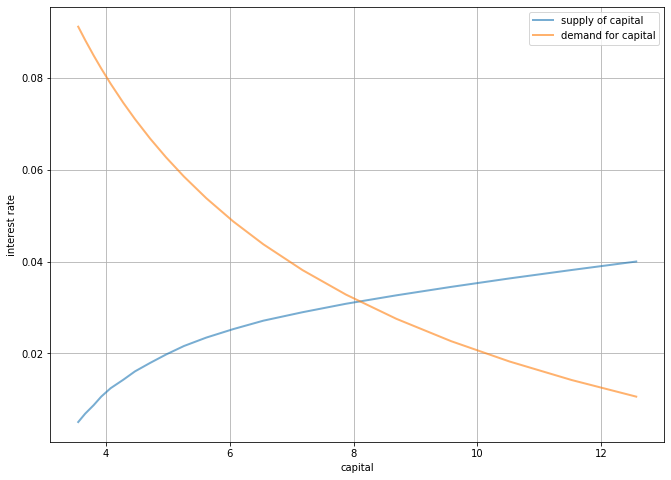

In [4]:
N = 1.0
A = 1.0   # Technology
α = 0.33  # Capital share
δ = 0.05  # Depreciation rate

def r_to_w(r):    
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  
    The interest rate associated with a given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.

    Parameters:
    ----------
    am : Household
         An instance of an aiyagari_household.Household
    r  : float
         The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)                       # Given (r,w), populate the reward function R
    aiyagari_ddp = DiscreteDP(am.R, am.Q, am.β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)    
    # Return K
    return np.sum(asset_probs * am.a_vals)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()